In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
pd.options.mode.chained_assignment = None  
from scipy import optimize,interpolate
import sklearn 
from sklearn.cluster import DBSCAN
#%run Routines_and_data/extract_func_3D.py
%run ROUTINES/gauss.py
%run ROUTINES/gauss_asym.py
import scipy
from lmfit import Model
from mpl_point_clicker import clicker


/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=Tr

In [2]:
print(pd.__version__)

0.23.4


In [3]:
%matplotlib widget

## Property Data

In [4]:
id_halo = '11'
df = pd.read_csv(f'DATA/processed/TracingPoints/data_rho_{id_halo}_.csv')

Xs    = df.x
Ys    = df.y
prop_final = df.rho_resta_final_exp

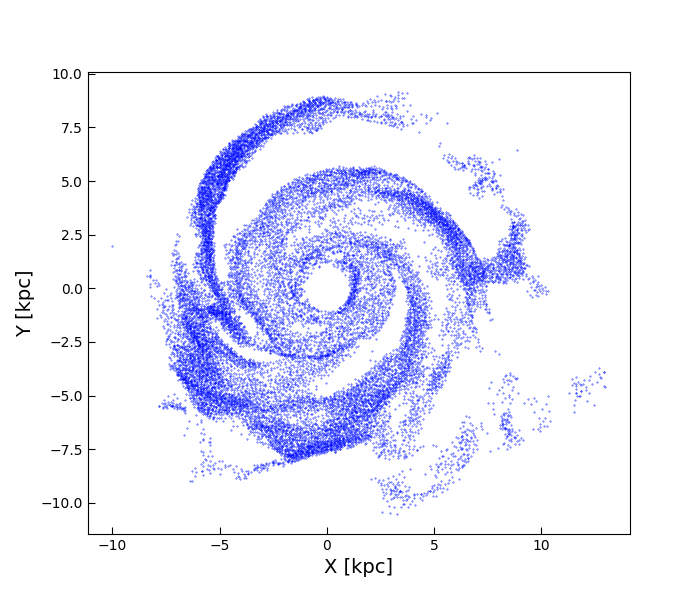

In [27]:
%matplotlib widget

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

# Graficar puntos
plt.figure(figsize=(7, 6))

plt.scatter(Xs, Ys, s=0.13, alpha=0.15 ,c='deepskyblue')
plt.scatter(Xs, Ys, s=0.1, alpha=0.87 ,c='blue')

plt.xlabel('X [kpc]', fontsize=14)  # Aumentar tamaño de la etiqueta del eje X
plt.ylabel('Y [kpc]', fontsize=14) 
plt.xlim()
plt.ylim()
# Ajustar los ejes a la misma escala
plt.axis('equal')

plt.show()


In [6]:
b=0.4 #valor david b=0.4
min_prop  = np.min(prop_final[ np.absolute(Ys) < b])

Xs_band   = Xs[ (np.absolute(Ys) < b) ]
Ys_band   = Ys[ (np.absolute(Ys) < b) ]
prop_band = prop_final[ np.absolute(Ys) < b]-min_prop

In [7]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False


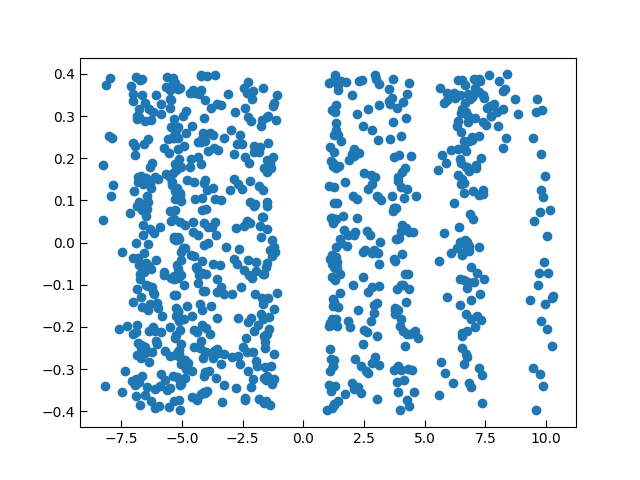

In [8]:
%matplotlib widget
plt.scatter(Xs_band, Ys_band,alpha=1);


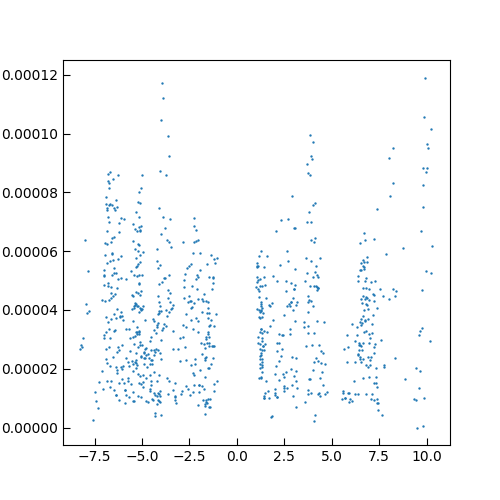

In [9]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(Xs_band, prop_band,s=0.5,alpha=1)

#ax.set_xlim()

## Arm Tracing Points Data

In [28]:
samplig_freq=1
df_arm1 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm1_rho_dani.csv')
df_arm1['arm'] = [1]*len(df_arm1)
df_arm1['id'] = np.arange(0,len(df_arm1),1)
df_arm1 = df_arm1[::samplig_freq].reset_index(drop=True)

df_arm2 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm2_rho_dani.csv')
df_arm2['arm'] = [2]*len(df_arm2)
df_arm2['id'] = np.arange(0,len(df_arm2),1)
df_arm2 = df_arm2[::samplig_freq].reset_index(drop=True)

df_arms = pd.concat([df_arm1,df_arm2], axis = 0).reset_index(drop=True)

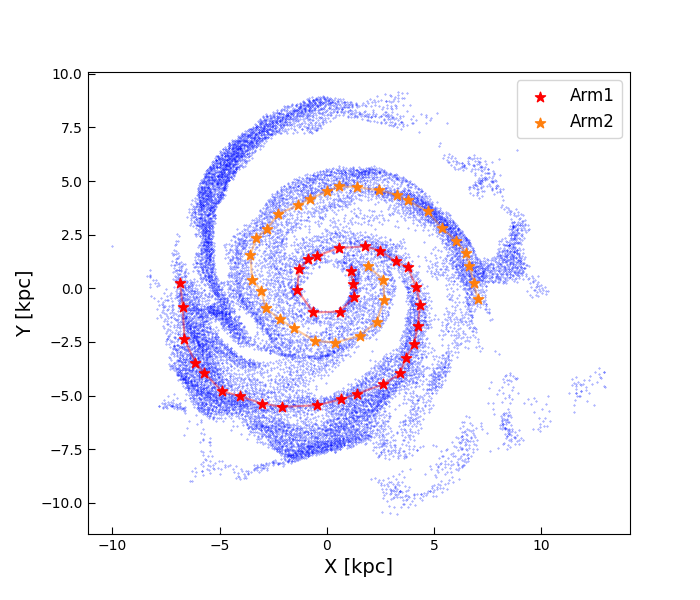

In [47]:

#ax.set_xlim(-R,R)
#ax.set_ylim(-R,R)
#ax.set_aspect('equal')

# Graficar puntos
plt.figure(figsize=(7, 6))

plt.scatter(df.x, df.y, s=0.13, alpha=0.10 ,c='deepskyblue')
plt.scatter(df.x, df.y, s=0.1, alpha=0.57 ,c='blue')
plt.scatter(df_arm1.x, df_arm1.y, s = 58, color = 'red', marker='*', label='Arm1')
plt.plot(df_arm1.x, df_arm1.y, '-', color = 'red', alpha=0.4)

plt.scatter(df_arm2.x, df_arm2.y, s = 58, color = 'C1', marker='*', label='Arm2')
plt.plot(df_arm2.x, df_arm2.y, '-', color = 'C1', alpha=0.4)


plt.xlabel('X [kpc]', fontsize=14)  # Aumentar tamaño de la etiqueta del eje X
plt.ylabel('Y [kpc]', fontsize=14) 
plt.xlim()
plt.ylim()
plt.legend(fontsize=12)
# Ajustar los ejes a la misma escala
plt.axis('equal')

plt.show()


## Rotations

In [12]:
def rotate(x, y, radians):
    x_rot = x * np.cos(radians) + y * np.sin(radians)
    y_rot = -x * np.sin(radians) + y * np.cos(radians)
    return {'x_rot':x_rot,'y_rot':y_rot}

In [13]:
def get_rotations(df_data, x_rot, y_rot):
    Xs = df_data.x
    Ys = df_data.y
    
    if x_rot > 0 and y_rot > 0 :
        a = np.arctan(y_rot/x_rot)
        return rotate(Xs, Ys, a), a

    elif x_rot < 0 and y_rot > 0:
        a = np.arctan(y_rot/x_rot) + np.pi
        return rotate(Xs, Ys, a), a    
    
    elif x_rot < 0 and y_rot < 0:
        a = np.arctan(y_rot/x_rot) + np.pi
        return rotate(Xs, Ys, a), a   
    
    elif x_rot > 0 and y_rot < 0:
        a = np.arctan(y_rot/x_rot) + 2*np.pi
        return rotate(Xs, Ys, a), a 

In [14]:
def get_rotated_arm_profile(prop, rotation_coords, b):
    x_rot = rotation_coords['x_rot']
    y_rot = rotation_coords['y_rot']
    
    min_prop  = np.min(prop[ np.absolute(y_rot)<b] )
    x_band = x_rot[ (np.absolute(y_rot)<b) ]
    y_band = prop[ np.absolute(y_rot)<b] - min_prop
    
    return {'x_band':x_band,'y_band':y_band}

In [15]:
b = 0.3

In [16]:
df_arm1['rotation_info'] = df_arm1.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arm1['rotation_coords'] = df_arm1.apply(lambda row: row.rotation_info[0], axis = 1)
df_arm1['alpha'] = df_arm1.apply(lambda row: row.rotation_info[1], axis = 1)
df_arm1['All_tracingPoints_rot'] = df_arm1.apply(lambda row: rotate(df_arm1.x, df_arm1.y, row.alpha), axis = 1)
df_arm1['This_tracingPoint_rot'] = df_arm1.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arm1['rotated_arm_profile'] = df_arm1.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)


df_arm2['rotation_info'] = df_arm2.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arm2['rotation_coords'] = df_arm2.apply(lambda row: row.rotation_info[0], axis = 1)
df_arm2['alpha'] = df_arm2.apply(lambda row: row.rotation_info[1], axis = 1)
df_arm2['All_tracingPoints_rot'] = df_arm2.apply(lambda row: rotate(df_arm2.x, df_arm2.y, row.alpha), axis = 1)
df_arm2['This_tracingPoint_rot'] = df_arm2.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arm2['rotated_arm_profile'] = df_arm2.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)



df_arms['rotation_info'] = df_arms.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arms['rotation_coords'] = df_arms.apply(lambda row: row.rotation_info[0], axis = 1)
df_arms['alpha'] = df_arms.apply(lambda row: row.rotation_info[1], axis = 1)
df_arms['All_tracingPoints_rot'] = df_arms.apply(lambda row: rotate(df_arms.x, df_arms.y, row.alpha), axis = 1)
df_arms['This_tracingPoint_rot'] = df_arms.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arms['rotated_arm_profile'] = df_arms.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)

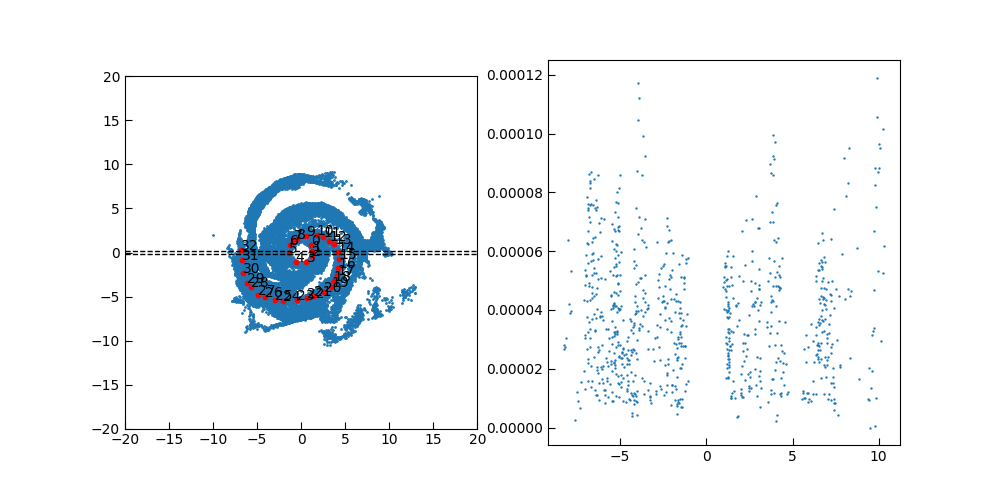

In [17]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(Xs_band,prop_band,s=0.5,alpha=1)

ax.set_aspect('equal')

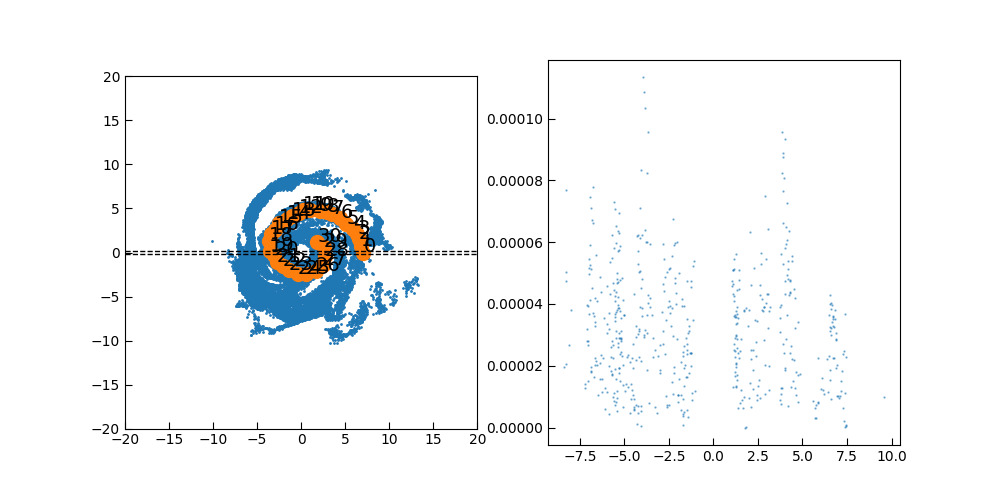

In [18]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
n = 0
ax.scatter(df_arm2.iloc[n].rotation_coords['x_rot'], df_arm2.iloc[n].rotation_coords['y_rot'], s = 1)
ax.scatter(df_arm2.iloc[n].All_tracingPoints_rot['x_rot'], df_arm2.iloc[n].All_tracingPoints_rot['y_rot'], s = 100)

for x, y, id in zip(df_arm2.iloc[n].All_tracingPoints_rot['x_rot'],df_arm2.iloc[n].All_tracingPoints_rot['y_rot'], df_arm2.id):
    ax.text(x, y, str(int(id)), fontsize = 14)

ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(df_arm2.iloc[n].rotated_arm_profile['x_band'], df_arm2.iloc[n].rotated_arm_profile['y_band'], s = 0.5, alpha = 0.5)

ax.set_aspect('equal')

# Fitting Procedure

In [19]:
df_params = pd.DataFrame({
    'amplitude': [],
    'stderr_amplitude': [],
    'center': [],
    'stderr_center': [],
    'sigma': [],
    'stderr_sigma': [],
    'gamma': [],
    'stderr_gamma': [],
    'x': [],
    'y': [],
    'delta': [],
    'x_tracing': [],
    'y_tracing': [],
    'id_tracing': []
})


In [20]:
#df_params = pd.DataFrame(columns = ['amplitude','stderr_amplitude','center','stderr_center',
                                   # 'sigma','stderr_sigma','gamma','stderr_gamma',
                                   # 'x','y','delta','x_tracing','y_tracing','id_tracing'])

In [21]:
arm = df_arm2.copy(deep=True)

In [22]:
arm

,x,y,arm,id,rotation_info,rotation_coords,alpha,All_tracingPoints_rot,This_tracingPoint_rot,rotated_arm_profile
0,7.037338,-0.500406,2,0,"({'x_rot': [-0.44350415701741497, -0.457357437...","{'x_rot': [-0.44350415701741497, -0.4573574376...",6.212198,"{'x_rot': [7.055106475640279, 6.80828663805833...","{'x_rot': 7.055106475640279, 'y_rot': 4.329869...","{'x_band': [1.0345252045018196, 1.196054137248..."
1,6.842532,0.239854,2,1,"({'x_rot': [-0.3389336499849233, -0.3471743341...","{'x_rot': [-0.3389336499849233, -0.34717433412...",0.035039,"{'x_rot': [7.0154879653197995, 6.8467350219438...","{'x_rot': 6.846735021943828, 'y_rot': 2.775557...","{'x_band': [1.0508493249668203, 1.090739282326..."
2,6.647727,1.058036,2,2,"({'x_rot': [-0.21314809955074385, -0.214777119...","{'x_rot': [-0.21314809955074385, -0.2147771190...",0.157834,"{'x_rot': [6.871210861610522, 6.79518050770864...","{'x_rot': 6.731397883446352, 'y_rot': 0.0}","{'x_band': [1.055000280341612, 1.1055147282109..."
3,6.491883,1.642451,2,3,"({'x_rot': [-0.11884284414484356, -0.115606503...","{'x_rot': [-0.11884284414484356, -0.1156065036...",0.247801,"{'x_rot': [6.699640310066557, 6.69235105688029...","{'x_rot': 6.696431338547244, 'y_rot': 2.220446...","{'x_band': [1.047951302331795, 1.1081405251515..."
4,6.024351,2.226867,2,4,"({'x_rot': [-0.006274380098499843, 0.002671980...","{'x_rot': [-0.006274380098499843, 0.0026719809...",0.354067,"{'x_rot': [6.427315847105859, 6.50125380009856...","{'x_rot': 6.4227515023901, 'y_rot': 0.0}","{'x_band': [1.0287149099206176, 1.128281212647..."
5,5.362013,2.811282,2,5,"({'x_rot': [0.13016822861358823, 0.14589554760...","{'x_rot': [0.13016822861358823, 0.145895547609...",0.482895,"{'x_rot': [6.000287657581282, 6.17149358361852...","{'x_rot': 6.0542953665270876, 'y_rot': 0.0}","{'x_band': [1.135617544361766, 1.1049513943084..."
6,4.699675,3.590503,2,6,"({'x_rot': [0.3060413021864013, 0.330275789569...","{'x_rot': [0.3060413021864013, 0.3302757895690...",0.652395,"{'x_rot': [5.288304579472934, 5.58291102087846...","{'x_rot': 5.914276094528197, 'y_rot': 4.440892...","{'x_band': [1.1166196397896415, 1.134885573734..."
7,3.764610,4.096997,2,7,"({'x_rot': [0.47860795723257715, 0.51090551341...","{'x_rot': [0.47860795723257715, 0.510905513414...",0.827653,"{'x_rot': [4.393033796006006, 4.80631412900675...","{'x_rot': 5.56396205789336, 'y_rot': 8.8817841...","{'x_band': [1.1593780525304291, 1.260375482174..."
8,3.258117,4.369724,2,8,"({'x_rot': [0.5730220646084936, 0.609589690557...","{'x_rot': [0.5730220646084936, 0.6095896905576...",0.930110,"{'x_rot': [3.80537248374598, 4.282383975977345...","{'x_rot': 5.450670939180415, 'y_rot': 0.0}","{'x_band': [1.082436130260307, 1.1572473519404..."
9,2.439935,4.564529,2,9,"({'x_rot': [0.6999764908174789, 0.742085120051...","{'x_rot': [0.6999764908174789, 0.7420851200511...",1.079898,"{'x_rot': [2.8762168319934105, 3.4372243831763...","{'x_rot': 5.175732810766709, 'y_rot': -4.44089...","{'x_band': [1.1047830005645491, 1.142420763650..."


(-2.5, 2.5)

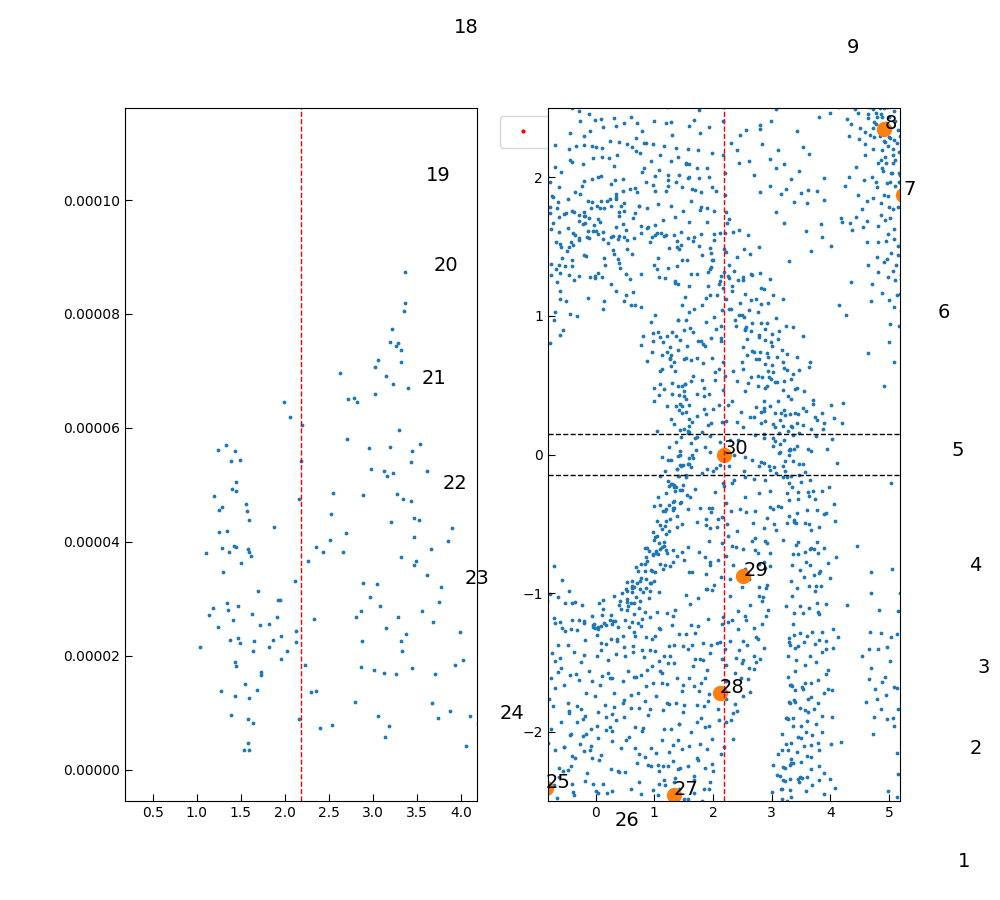

In [668]:
%matplotlib widget

n= 30 #n = 86
fig, (ax,ax2) = plt.subplots(figsize=(10,9), ncols = 2)

x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
y_tracing = arm.iloc[n].This_tracingPoint_rot['y_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 3, alpha = 1)
#ax.set_xlim(0,np.max(x_band)+1)
ax.set_xlim(x_tracing-2,x_tracing+2)
klicker = clicker(ax, ["limits"], markers=["o"], colors = ['red'], markersize = 2)
x_tracing_all = arm.iloc[n].All_tracingPoints_rot['x_rot']
y_tracing_all = arm.iloc[n].All_tracingPoints_rot['y_rot']
x_coords = arm.iloc[n].rotation_coords['x_rot']
y_coords = arm.iloc[n].rotation_coords['y_rot']
ax2.scatter(x_coords, y_coords, s = 3)
ax2.scatter(x_tracing_all, y_tracing_all, s = 100)
for x, y, id in zip(x_tracing_all,y_tracing_all, arm.id):
    ax2.text(x, y, str(int(id)), fontsize = 14)
   
ax2.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
ax2.axhline(y=b/2,ls='--',lw=1,color='black')
ax2.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax2.set_xlim(x_tracing-3,x_tracing+3)
ax2.set_ylim(-2.5,2.5)

## %run Routines_and_data/gauss_asym.py

In [669]:
dict_lims = klicker.get_positions()
#print(dict_lims)

In [670]:
dict_lims

{'limits': array([[1.39060071e+00, 6.41495200e-06],
        [1.41331039e+00, 1.92338809e-05],
        [1.52685877e+00, 2.66091551e-05],
        [1.66311684e+00, 3.39844292e-05],
        [1.70853619e+00, 4.04816946e-05],
        [1.77666523e+00, 4.99641899e-05],
        [1.83343942e+00, 5.87442782e-05],
        [1.89021361e+00, 6.59439506e-05],
        [2.04918135e+00, 7.38460300e-05],
        [2.31034264e+00, 7.03339947e-05],
        [2.37847168e+00, 6.47147382e-05],
        [2.43524587e+00, 5.75150658e-05],
        [2.54879426e+00, 5.24226146e-05],
        [2.62827813e+00, 4.62765528e-05],
        [2.70776200e+00, 4.20621104e-05],
        [2.74182652e+00, 3.99548893e-05],
        [2.76453619e+00, 3.87256769e-05],
        [2.94621361e+00, 3.38088275e-05],
        [3.02569748e+00, 2.97699868e-05],
        [3.12789103e+00, 2.67847568e-05],
        [3.19602006e+00, 2.50287392e-05],
        [3.26414910e+00, 2.22191109e-05],
        [3.33227813e+00, 1.88826774e-05],
        [3.38905232e+00,

In [671]:
delta = 0.05
model = get_asym_gaussian_fit(dict_lims,arm,n,delta)

/home/daniel/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


In [672]:
n

30

(9.05788519850928e-15, 4.573930551529624e-05)

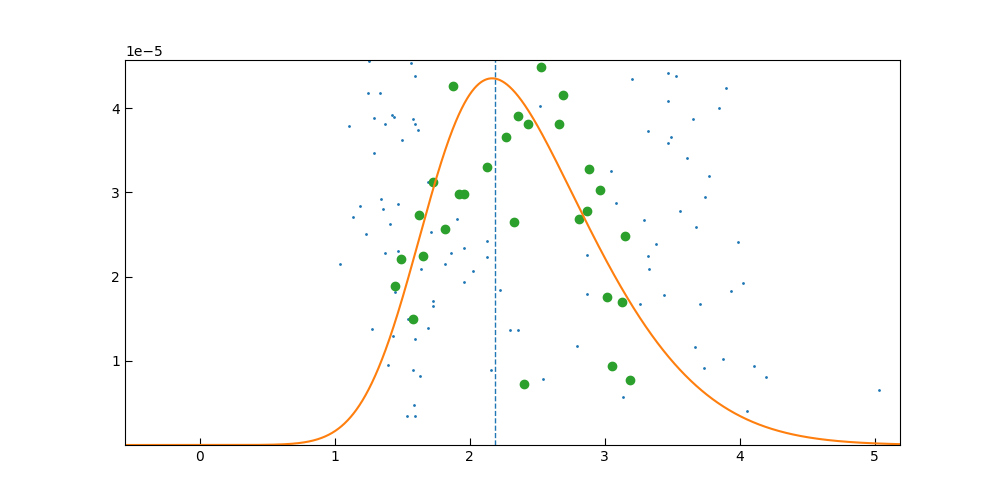

In [673]:
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1, marker = 'o')

fitted_model = eval_fitted_model(model)
ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o')

ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

In [674]:
fractured = False

In [675]:
df_params = add_row_with_param_info(model, df_params, arm.iloc[n], delta, fractured)

In [676]:
df_params.tail()

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing
26,0.000102,2.847629,0.05,False,-7.102345,26.0,1.150720,0.000009,0.045174,4.000567,0.159005,"[1.233947062070646, 1.2823010333553801, 1.2946...",1.543831,"[3.6117546269707386e-05, 3.766079270417303e-05...",-2.214692
27,0.000197,3.484678,0.05,False,-3.771029,27.0,1.895303,0.000076,0.713918,7.182348,0.357837,"[1.1051939413591207, 1.1588936853846716, 1.213...",2.323052,"[4.57036306558723e-05, 4.752107814444142e-05, ...",-1.552354
28,0.000098,1.696839,0.05,False,6.453588,28.0,1.459714,0.000027,0.084845,5.677711,0.590316,"[1.5075502589795953, 1.6222178526582258, 1.663...",2.673701,"[1.5074951864252314e-05, 1.5004301520407065e-0...",-0.539367
29,0.000109,1.699336,0.05,False,8.051088,29.0,1.496507,0.000023,0.083802,6.025661,0.441966,"[1.3821005384397151, 1.48134362337005, 1.49499...",2.634740,"[9.04878921828795e-06, 9.724598179784362e-06, ...",0.395698
30,0.000068,1.674546,0.05,False,2.613503,30.0,0.989956,0.000007,0.121100,2.056006,0.248966,"[1.4481882006883326, 1.4938663103247118, 1.580...",1.933442,"[1.8939915106808658e-05, 2.2153152798373383e-0...",1.019075


In [677]:
df_copy = df_params.copy()
#df_params.drop([26], inplace = True)

In [678]:
df_params

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing
0,0.000036,6.345431,0.05,False,1.382571,0.0,0.542836,0.000003,0.179707,1.386284,0.176604,"[5.700605583416785, 5.779585085369988, 5.85433...",7.037338,"[6.225138528796177e-06, 7.294953548256233e-06,...",-0.500406
1,0.000106,6.132722,0.05,False,2.506467,1.0,1.199615,0.000009,0.111989,1.218205,0.237085,"[5.542732744087904, 5.604833997041834, 5.68830...",6.842532,"[9.707063587437786e-06, 1.187300000104887e-05,...",0.239854
2,0.000121,5.974326,0.05,False,2.244582,2.0,1.071093,0.000008,0.109682,1.074577,0.199145,"[5.4014469848347195, 5.460614006033617, 5.5273...",6.647727,"[1.2587880729392635e-05, 1.8976680113200644e-0...",1.058036
3,0.000111,6.155651,0.05,False,1.542169,3.0,0.798188,0.000024,0.361243,2.474840,0.560240,"[5.1566660843038115, 5.280330476415054, 5.4754...",6.491883,"[1.045883169149695e-05, 1.4751157000772444e-05...",1.642451
4,0.000089,6.840104,0.05,False,-1.308188,4.0,0.571843,0.000005,0.099404,0.940481,0.094320,"[5.120745440579302, 5.294771208065151, 5.41164...",6.024351,"[5.522168090477334e-06, 1.5405218869518015e-05...",2.226867
5,0.000061,6.032013,0.05,False,1.422274,5.0,0.412595,0.000005,0.128563,1.429715,0.150838,"[5.034282213046533, 5.386328529543269, 5.45596...",5.362013,"[6.49585759432214e-06, 6.9451552072466e-06, 7....",2.811282
6,0.000098,6.318952,0.05,False,-7.454106,6.0,0.961633,0.000003,0.010434,1.436918,0.047303,"[5.106235787813379, 5.121770826388576, 5.19117...",4.699675,"[3.230718968436138e-05, 3.89390517177155e-05, ...",3.590503
7,0.000070,6.015999,0.05,False,-2.858479,7.0,0.843329,0.000003,0.038761,0.795748,0.082390,"[4.279214611646735, 4.508294331561057, 4.65384...",3.764610,"[7.07427680255262e-06, 1.87436406632659e-05, 2...",4.096997
8,0.000089,5.914703,0.05,False,-3.070113,8.0,1.150173,0.000007,0.069798,1.225535,0.165152,"[3.9387396632230613, 4.037374574251024, 4.1811...",3.258117,"[1.796777721095486e-05, 2.4828890608016135e-05...",4.369724
9,0.000089,5.914703,0.05,False,-3.070113,9.0,1.150173,0.000007,0.069798,1.225535,0.165152,"[3.9387396632230613, 4.037374574251024, 4.1811...",2.439935,"[1.796777721095486e-05, 2.4828890608016135e-05...",4.564529


In [679]:
df_params['y']

0     [6.225138528796177e-06, 7.294953548256233e-06,...
1     [9.707063587437786e-06, 1.187300000104887e-05,...
2     [1.2587880729392635e-05, 1.8976680113200644e-0...
3     [1.045883169149695e-05, 1.4751157000772444e-05...
4     [5.522168090477334e-06, 1.5405218869518015e-05...
5     [6.49585759432214e-06, 6.9451552072466e-06, 7....
6     [3.230718968436138e-05, 3.89390517177155e-05, ...
7     [7.07427680255262e-06, 1.87436406632659e-05, 2...
8     [1.796777721095486e-05, 2.4828890608016135e-05...
9     [1.796777721095486e-05, 2.4828890608016135e-05...
10    [2.5955691898300655e-05, 2.7328337163132483e-0...
11    [4.79353915862939e-06, 2.297670118176783e-05, ...
12    [1.3912444609616456e-05, 4.10046483118526e-06,...
13    [1.8827525549998663e-05, 7.308252265116286e-06...
14    [1.717849194735669e-05, 2.4805298785000292e-05...
15    [1.9870621209379324e-05, 2.0641978245333535e-0...
16    [1.132600932908869e-05, 1.7254205661849876e-05...
17    [2.390081421816179e-05, 2.7133323512373533

In [680]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
params

amplitude                                                 6.77204e-05
center                                                        1.67455
delta                                                            0.05
fractured                                                       False
gamma                                                          2.6135
id_tracing                                                         30
sigma                                                        0.989956
stderr_amplitude                                          7.07063e-06
stderr_center                                                  0.1211
stderr_gamma                                                  2.05601
stderr_sigma                                                 0.248966
x                   [1.4481882006883326, 1.4938663103247118, 1.580...
x_tracing                                                     1.93344
y                   [1.8939915106808658e-05, 2.2153152798373383e-0...
y_tracing           

In [681]:
from shapely.geometry import LineString

def find_widths_of_skewed_gaussian_dani(params, dx=0.05):
    # Evaluar el modelo ajustado
    fitted_model = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = fitted_model['x_eval']
    y_eval = fitted_model['y_eval']

    # Encuentra el máximo
    x_max, y_max = find_maximum(x_eval, y_eval)

    # Generar la línea horizontal en y = y_max / 2
    xs_line = np.arange(np.min(x_eval), np.max(x_eval), 0.01)
    ys_line = np.full(len(xs_line), 0.5 * y_max)

    # Crear LineString para las dos líneas
    first_line = LineString(np.column_stack((x_eval, y_eval)))
    second_line = LineString(np.column_stack((xs_line, ys_line)))
    intersection = first_line.intersection(second_line)

    points_intercept = []

    if intersection.geom_type == 'Point':
        points_intercept = [(intersection.x, intersection.y)]
    elif hasattr(intersection, 'geoms'):
        points_intercept = [(point.x, point.y) for point in intersection.geoms]
    elif intersection.is_empty:
        return {'x_max': x_max, 'y_max': y_max, 'w1': np.nan, 'w2': np.nan}

    # Asegurarse de que hay suficientes puntos de intersección
    if len(points_intercept) >= 2:
        w1 = x_max - points_intercept[1][0]
        w2 = points_intercept[0][0] - x_max
    else:
        w1, w2 = np.nan, np.nan  # Si no hay suficientes intersecciones

    return {'x_max': x_max, 'y_max': y_max, 'w1': w1, 'w2': w2}

def plot_fit_and_widths_dani(params, ax, dx=0.05):
    width_info = find_widths_of_skewed_gaussian_dani(params, dx=dx)

    dict_eval = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = dict_eval['x_eval']
    y_eval = dict_eval['y_eval']

    # Plotea la función ajustada
    ax.plot(x_eval, y_eval, lw=2.5, label='Fitted Function')

    # Máximos y anchos
    ax.axvline(x=width_info['x_max'], color='red', lw=1.5, label='x_max = {:.3f}'.format(width_info['x_max']))
    ax.axhline(y=width_info['y_max'], ls='--', color='k', label='y_max = {:.2e}'.format(width_info['y_max']))
    ax.axhline(y=0.5 * width_info['y_max'], color='green', lw=1.5, label='y_max / 2 = {:.2e}'.format(0.5 * width_info['y_max']))

    # Líneas verticales para w1 y w2
    ax.axvline(x=np.abs(width_info['x_max'] - width_info['w1']), color='magenta', lw=1.5, ls='--', label='w1 = {:.3f}'.format(width_info['w1']))
    ax.axvline(x=np.abs(width_info['x_max'] + width_info['w2']), color='purple', lw=1.5, ls='--', label='w2 = {:.3f}'.format(width_info['w2']))

    # Ajustar etiquetas de los ticks
    xt = ax.get_xticks()
    tick1 = '{:.2f}'.format(np.abs(width_info['x_max'] - width_info['w1']))
    tick2 = '{:.2f}'.format(np.abs(width_info['x_max'] + width_info['w2']))
    xt = np.append(xt, [float(tick1), float(tick2)])

    ax.set_xticks(xt)
    ax.set_xticklabels(xt)

    ax.grid(alpha=0.5, lw=1, ls='--')
    ax.legend(loc='upper left')



In [682]:
arm.iloc[n].id

30

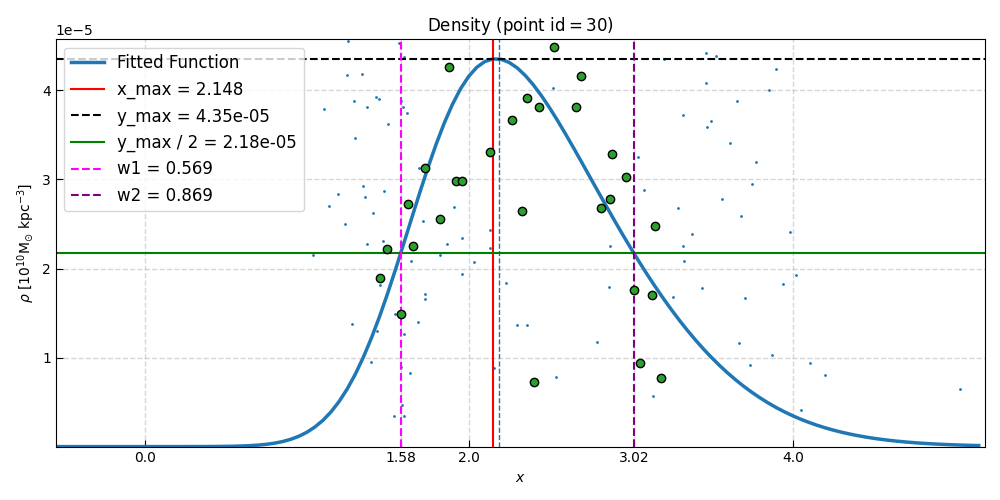

In [683]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1)

fitted_model = eval_fitted_model(model)
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o',  linewidths = 1, edgecolors = 'k', zorder = 10)

ax.set_xlim(0,np.max(x_band)+1)
plot_fit_and_widths_dani(params, ax)
ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

#ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')


ax.set_xlabel(r'$x$')
rho_units      = r"$ \rho \ [10^{10} \mathrm{M}_{\odot} \ \mathrm{kpc}^{-3}] $"
ax.set_ylabel(rho_units)
ax.set_title(r'$\mathrm{{Density}} \ (\mathrm{{point \ id}}={{{0}}})$'.format(arm.iloc[n].id))
fig.tight_layout()
fig.savefig(f'FIT_PLOTS/rho_point_id_{n}_arm2_halo{id_halo}_.png',dpi=200)

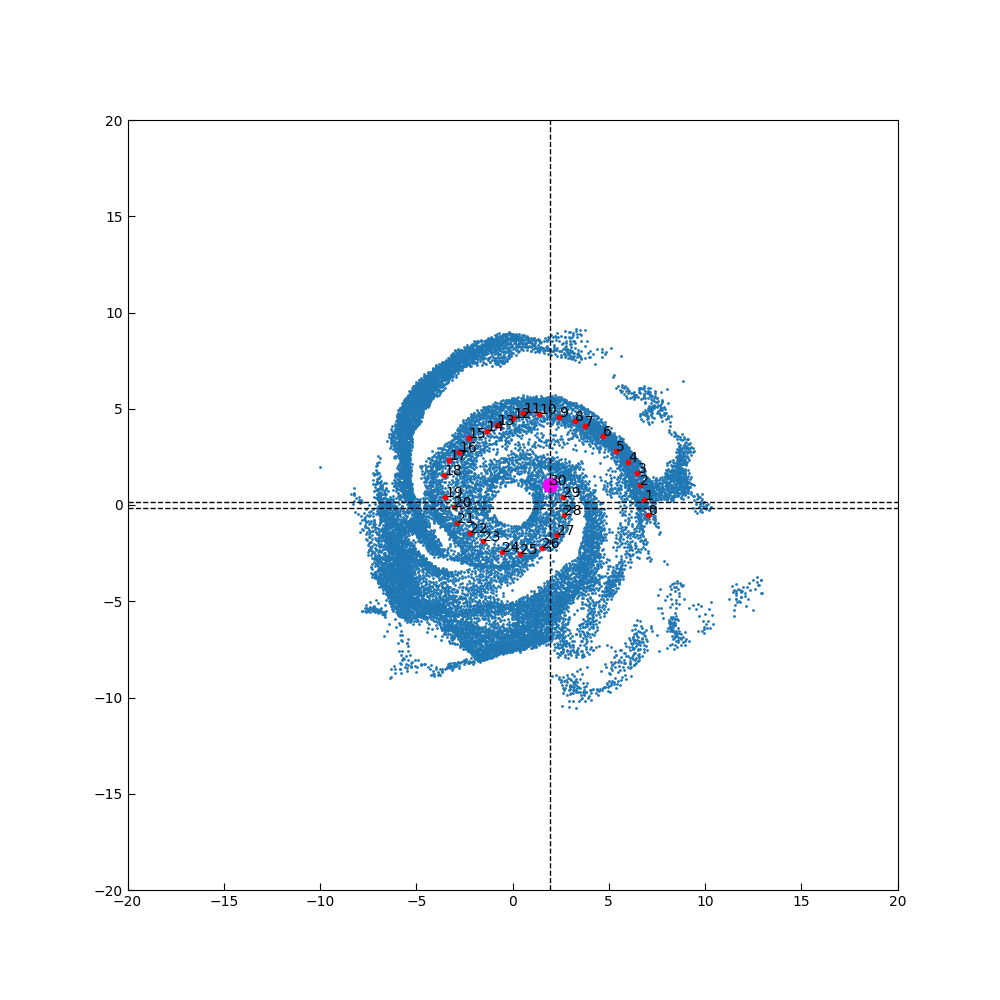

In [684]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm2.x, df_arm2.y, s = 10, color = 'red')
ax.scatter(df_params.iloc[n_actual].x_tracing,df_params.iloc[n_actual].y_tracing,color='magenta',s = 100)
ax.axvline(x=df_params.iloc[n_actual].x_tracing,ls='--',lw=1,color='black')

for i, row in df_arm2.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax.set_aspect('equal')

In [685]:
df_params.to_csv(f'FIT_INFO/fit_params_rho_arm2_adicionales_HALO{id_halo}.csv', index = False)

df_params.to_csv(f'FIT_INFO/fit_params_rho_arm2_all_points_HALO{id_halo}_.csv', index = False)

df_params.to_csv('df_params_rho_arm2_all_points_HALO{id_halo}_partial.csv')

In [166]:
df_params.to_csv('df_params_rho_arm2_adicionales_dani.csv')

## arm 1

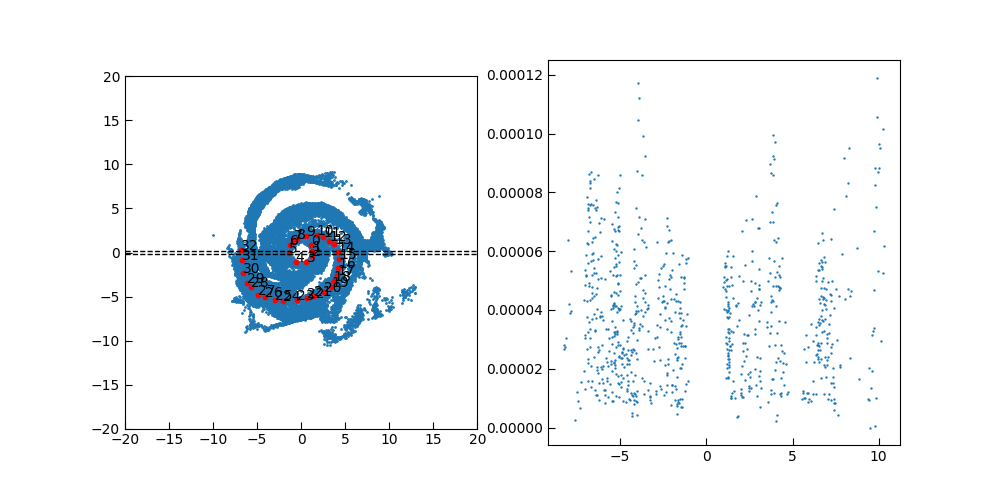

In [686]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(Xs_band,prop_band,s=0.5,alpha=1)

ax.set_aspect('equal')

In [687]:
df_params = pd.DataFrame({
    'amplitude': [],
    'stderr_amplitude': [],
    'center': [],
    'stderr_center': [],
    'sigma': [],
    'stderr_sigma': [],
    'gamma': [],
    'stderr_gamma': [],
    'x': [],
    'y': [],
    'delta': [],
    'x_tracing': [],
    'y_tracing': [],
    'id_tracing': []
})

arm = df_arm1.copy(deep=True)

In [688]:
arm

,x,y,arm,id,rotation_info,rotation_coords,alpha,All_tracingPoints_rot,This_tracingPoint_rot,rotated_arm_profile
0,1.115260,0.824269,1,0,"({'x_rot': [0.28982218095021234, 0.31328368946...","{'x_rot': [0.28982218095021234, 0.313283689464...",0.636478,"{'x_rot': [1.3868036864531588, 1.1102863288136...","{'x_rot': 1.3868036864531588, 'y_rot': 0.0}","{'x_band': [1.1197805354711825, 1.130919139347..."
1,1.232143,0.200893,1,1,"({'x_rot': [-0.2092072640328119, -0.2106314394...","{'x_rot': [-0.2092072640328119, -0.21063143947...",0.161621,"{'x_rot': [1.2333656382106306, 1.2484125762179...","{'x_rot': 1.2484125762179685, 'y_rot': -2.7755...","{'x_band': [1.054875421990205, 1.1057062874360..."
2,1.271104,-0.383523,1,2,"({'x_rot': [-0.6450447846799763, -0.6700759232...","{'x_rot': [-0.6450447846799763, -0.67007592328...",5.990147,"{'x_rot': [0.8296170644310431, 1.1215872855294...","{'x_rot': 1.327702827075853, 'y_rot': 6.106226...","{'x_band': [-1.0308492272146643, -1.0381138413..."
3,0.608766,-1.084821,1,3,"({'x_rot': [-1.04951148102202, -1.100809765975...","{'x_rot': [-1.04951148102202, -1.1008097659751...",5.223765,"{'x_rot': [-0.17303844659270096, 0.42779071773...","{'x_rot': 1.2439589459711582, 'y_rot': 1.11022...","{'x_band': [-1.04951148102202, -1.100809765975..."
4,-0.637987,-1.123782,1,4,"({'x_rot': [-0.6794430694705972, -0.7206738268...","{'x_rot': [-0.6794430694705972, -0.72067382687...",4.196048,"{'x_rot': [-1.2674162608794324, -0.78301387385...","{'x_rot': 1.2922517026777158, 'y_rot': 1.11022...","{'x_band': [-1.1027246838263156, -1.1354440735..."
5,-1.378247,-0.071834,1,5,"({'x_rot': [0.321747413718089, 0.3290761012189...","{'x_rot': [0.321747413718089, 0.32907610121897...",3.193666,"{'x_rot': [-1.156650821308798, -1.240929066795...","{'x_rot': 1.3801174935843579, 'y_rot': 0.0}","{'x_band': [-1.0523744640609751, -1.0937778642..."
6,-1.300325,0.902192,1,6,"({'x_rot': [0.8736649989340054, 0.912269088427...","{'x_rot': [0.8736649989340054, 0.9122690884279...",2.535026,"{'x_rot': [-0.44643413295897044, -0.8978221823...","{'x_rot': 1.5826540586563558, 'y_rot': -1.1102...","{'x_band': [1.0366964802274041, 1.102052180502..."
7,-0.871753,1.369724,1,7,"({'x_rot': [1.0390329422802398, 1.089300196608...","{'x_rot': [1.0390329422802398, 1.0893001966080...",2.137583,"{'x_rot': [0.09656922707246895, -0.49208772520...","{'x_rot': 1.6236063656426463, 'y_rot': -1.1102...","{'x_band': [1.0390329422802398, 1.089300196608..."
8,-0.443182,1.525568,1,8,"({'x_rot': [1.0584891206289964, 1.112349806987...","{'x_rot': [1.0584891206289964, 1.1123498069879...",1.853517,"{'x_rot': [0.4804220974895909, -0.150813256229...","{'x_rot': 1.5886372780918183, 'y_rot': 1.66533...","{'x_band': [1.0584891206289964, 1.112349806987..."
9,0.569805,1.876218,1,9,"({'x_rot': [0.8420578156010585, 0.889977329551...","{'x_rot': [0.8420578156010585, 0.8899773295514...",1.275950,"{'x_rot': [1.112786489714692, 0.55027609246270...","{'x_rot': 1.960834054469052, 'y_rot': 1.110223...","{'x_band': [1.0966417673085085, 1.171125424604..."


(-2.5, 2.5)

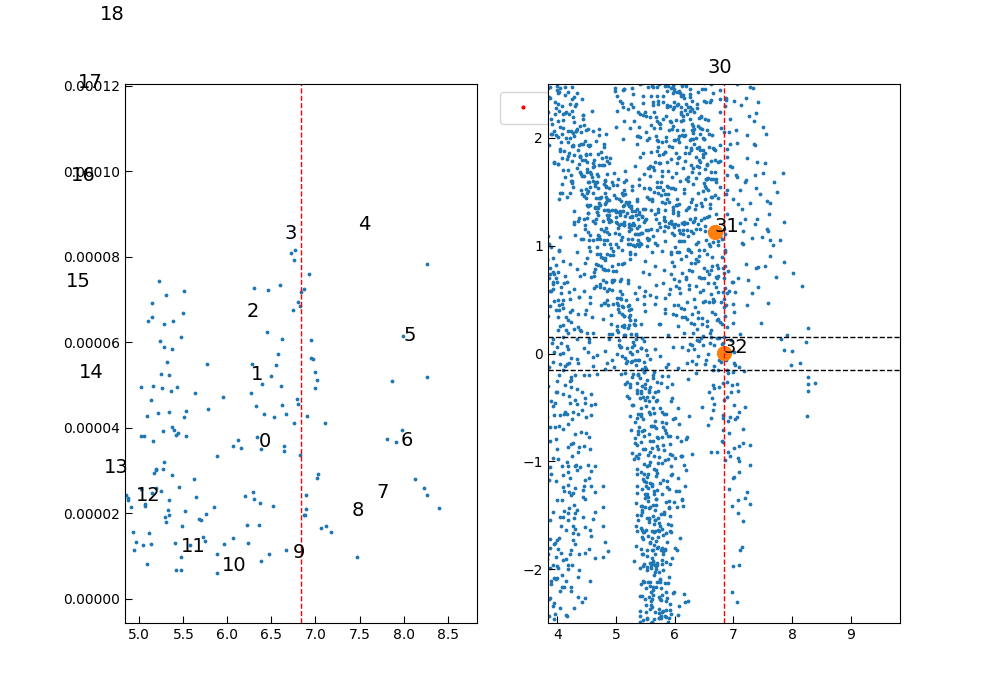

In [981]:
n= 32 #n = 86
fig, (ax,ax2) = plt.subplots(figsize=(10,7), ncols = 2)

x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
y_tracing = arm.iloc[n].This_tracingPoint_rot['y_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 3, alpha = 1)
#ax.set_xlim(0,np.max(x_band)+1)
ax.set_xlim(x_tracing-2,x_tracing+2)
klicker = clicker(ax, ["limits"], markers=["o"], colors = ['red'], markersize = 2)
x_tracing_all = arm.iloc[n].All_tracingPoints_rot['x_rot']
y_tracing_all = arm.iloc[n].All_tracingPoints_rot['y_rot']
x_coords = arm.iloc[n].rotation_coords['x_rot']
y_coords = arm.iloc[n].rotation_coords['y_rot']
ax2.scatter(x_coords, y_coords, s = 3)
ax2.scatter(x_tracing_all, y_tracing_all, s = 100)
for x, y, id in zip(x_tracing_all,y_tracing_all, arm.id):
    ax2.text(x, y, str(int(id)), fontsize = 14)
   
ax2.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
ax2.axhline(y=b/2,ls='--',lw=1,color='black')
ax2.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax2.set_xlim(x_tracing-3,x_tracing+3)
ax2.set_ylim(-2.5,2.5)

In [982]:
dict_lims = klicker.get_positions()
#print(dict_lims)

In [983]:
delta = 0.05
model = get_asym_gaussian_fit(dict_lims,arm,n,delta)

/home/daniel/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


(0.0, 7.833245385480321e-05)

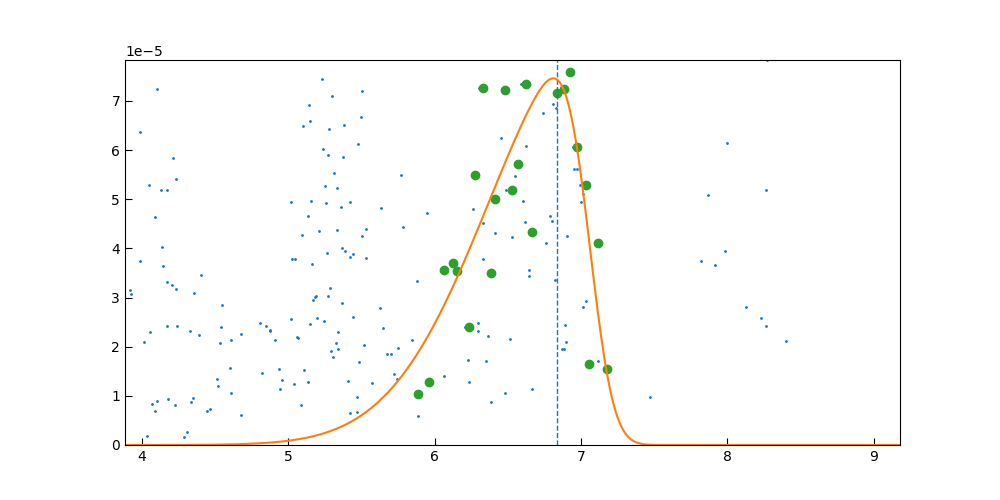

In [984]:
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1, marker = 'o')

fitted_model = eval_fitted_model(model)
ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o')

ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

In [985]:
fractured = False

df_params = add_row_with_param_info(model, df_params, arm.iloc[n], delta, fractured)

In [988]:
df_params

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing
0,0.000076,1.100783,0.05,False,3.314027,0.0,0.800582,0.000004,0.033709,1.369042,0.078732,"[1.0531389868545593, 1.1309191393479958, 1.158...",1.115260,"[3.660864705582006e-05, 4.215183384509996e-05,...",0.824269
1,0.000051,0.871990,0.05,False,1.994018,1.0,0.606178,0.000052,0.400654,7.892719,0.196534,"[1.0981897287359714, 1.1516658792975394, 1.198...",1.232143,"[5.0115605255302986e-05, 5.7126940830650164e-0...",0.200893
2,0.000027,1.059887,0.05,False,1.548838,2.0,0.325805,0.000007,0.174439,3.875247,0.203531,"[1.0246076336086145, 1.1229963510560774, 1.174...",1.271104,"[2.5913903287833956e-05, 4.49269817773002e-05,...",-0.383523
3,0.000094,0.989271,0.05,False,-0.007712,4.0,0.691054,0.000295,15710.193278,28505.286967,234.933110,"[1.066051845125667, 1.1169859086225353, 1.1650...",-0.637987,"[5.669878538619095e-05, 5.7949333853416975e-05...",-1.123782
4,0.000056,1.124091,0.05,False,11.050451,5.0,0.981666,0.000008,0.061417,10.410713,0.193507,"[1.074725249172557, 1.2239679540309005, 1.2725...",-1.378247,"[1.4061952941731587e-05, 3.286830570917144e-05...",-0.071834
5,0.000066,1.013858,0.05,False,4.472738,6.0,0.955734,0.000016,0.127183,7.250746,0.394686,"[1.0566886801979156, 1.1020521805023606, 1.182...",-1.300325,"[3.9447691113646336e-05, 3.6339962711142446e-0...",0.902192
6,0.000100,1.131881,0.05,False,5.579120,7.0,1.328062,0.000012,0.067463,3.563686,0.262230,"[1.0390329422802398, 1.089300196608018, 1.1336...",-0.871753,"[2.610137118179518e-05, 2.3366385743371645e-05...",1.369724
7,0.000095,1.124545,0.05,False,16.470138,8.0,1.392556,0.000018,0.043433,14.410655,0.350381,"[1.0584891206289964, 1.1123498069879363, 1.184...",-0.443182,"[1.6001854180740528e-05, 2.36683525439078e-05,...",1.525568
8,0.000085,2.856575,0.05,False,-4.966858,9.0,1.127564,0.000019,0.093958,4.476995,0.423762,"[1.4646651148106962, 1.6741992535810815, 1.683...",0.569805,"[1.710133802014321e-05, 2.5733099112251323e-05...",1.876218
9,0.000119,3.016282,0.05,False,-0.870829,10.0,1.081778,0.000012,1.590958,3.804473,1.079662,"[1.1595572316030305, 1.3094769666135442, 1.399...",1.777597,"[1.1502160386099793e-05, 2.4723727689678684e-0...",1.954140


In [986]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
params

amplitude                                                 7.01623e-05
center                                                         7.0574
delta                                                            0.05
fractured                                                       False
gamma                                                        -5.20175
id_tracing                                                         32
sigma                                                        0.681829
stderr_amplitude                                          5.38163e-06
stderr_center                                               0.0296571
stderr_gamma                                                  2.33988
stderr_sigma                                                0.0854241
x                   [5.884338996009094, 5.962868330964022, 6.06310...
x_tracing                                                    -6.83279
y                   [1.0466782838921967e-05, 1.2863078455568175e-0...
y_tracing           

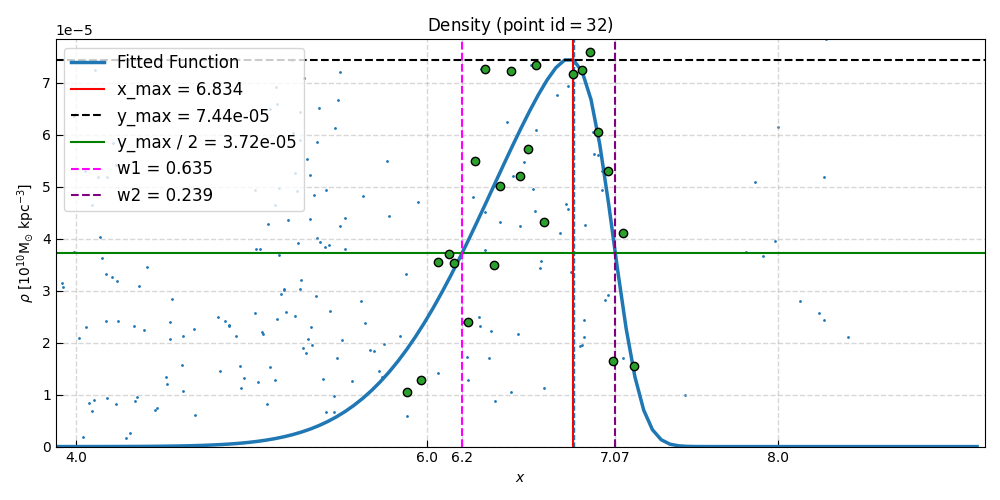

In [987]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1)

fitted_model = eval_fitted_model(model)
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o',  linewidths = 1, edgecolors = 'k', zorder = 10)

ax.set_xlim(0,np.max(x_band)+1)
plot_fit_and_widths_dani(params, ax)
ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

ax.set_xlabel(r'$x$')
rho_units      = r"$ \rho \ [10^{10} \mathrm{M}_{\odot} \ \mathrm{kpc}^{-3}] $"
ax.set_ylabel(rho_units)
ax.set_title(r'$\mathrm{{Density}} \ (\mathrm{{point \ id}}={{{0}}})$'.format(arm.iloc[n].id))
fig.tight_layout()
fig.savefig(f'FIT_PLOTS/rho_point_id_{n}_arm1_HALO{id_halo}_.png',dpi=200)

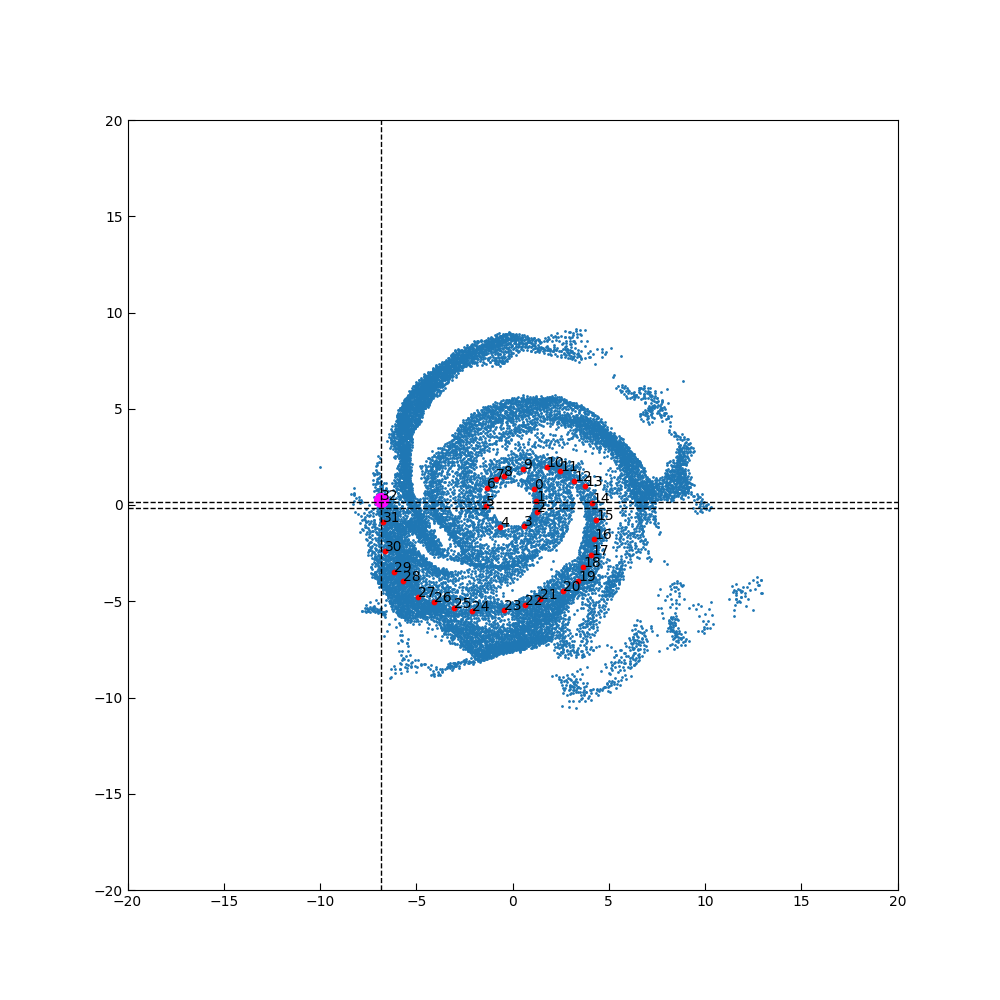

In [989]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
ax.scatter(df_params.iloc[n_actual].x_tracing,df_params.iloc[n_actual].y_tracing,color='magenta',s = 100)
ax.axvline(x=df_params.iloc[n_actual].x_tracing,ls='--',lw=1,color='black')

for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax.set_aspect('equal')

In [990]:
#df_params.to_csv(f'FIT_INFO/fit_params_rho_arm1_adicionales_HALO{id_halo}_.csv', index = False)

df_params.to_csv(f'FIT_INFO/fit_params_rho_arm1_all_points_HALO{id_halo}_.csv', index = False)

df_params.to_csv('df_params_rho_arm1_all_points_HALO{id_halo}_.csv')